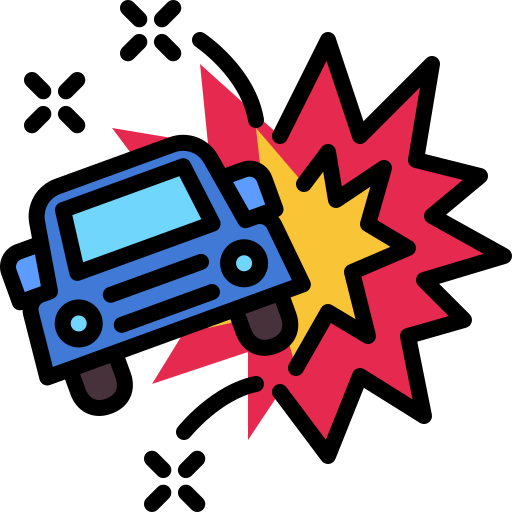

US Traffic Data

## Overview

The goal of this project is to analyze traffic collision data from the Department of Transportation in order to find actionable insight to improve driver safety. I compared the weights of each variable and their individual effect on the severity of accidents.

## Business Understanding

The dataset provided includes over 7,000,000 records of traffic accidents along with associated data pertaining to weather conditions, visibility, location, and time, as well as many other variables that may contribute to the risk and severity of traffic accidents. The Goal of this analysis is to identify trends that can reduce occurences and severity of traffic accidents.

## Data Understanding

The dataset provided contains information related to all accidents recorded, including over 40 variables of possibly related affects, such as weather, location, time of day, and others. The records are able to be split into categories such as night-time accidents, accidents in inclement weather, and daytime good weather categories. I also tried to separate them into clusters based on compute-based variables. This analysis is intended to find correlations that are not obvious at first glance but can lead to a further understanding of the cause of traffic collisions as well as the variables that have the most effect on severity of collisions.

In [1]:
import os, gc, psutil, traceback, shutil
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StringType, IntegerType, LongType, DoubleType, FloatType, BooleanType, DateType, TimestampType

# Configure dataset
CSV_PATH = "US_Accidents_March23.csv" 
KMEANS_K = 4
RANDOM_SEED = 42

# Determine safe sample fraction based on RAM (conservative)
ram_gb = psutil.virtual_memory().total / (1024**3)
if ram_gb >= 16:
    SAMPLE_FRAC = 0.02   # 2%
elif ram_gb >= 8:
    SAMPLE_FRAC = 0.01   # 1%
else:
    SAMPLE_FRAC = 0.005  # 0.5% or lower for small laptops

print(f"Detected RAM: {ram_gb:.1f} GB — using sample_frac = {SAMPLE_FRAC}")

# 1) Start / reset Spark session
try:
    spark.stop()
except Exception:
    pass

driver_mem = "10g" if ram_gb >= 16 else ("6g" if ram_gb >= 8 else "3g")
spark = (SparkSession.builder
         .appName("US_Accidents_Clustering_FullPipeline")
         .config("spark.driver.memory", driver_mem)
         .config("spark.executor.memory", driver_mem)
         .config("spark.sql.shuffle.partitions", "200")
         .config("spark.memory.fraction", "0.6")
         .config("spark.network.timeout", "600s")
         .getOrCreate())

print("Spark version:", spark.version)
print("Driver memory config:", driver_mem)

Detected RAM: 3.5 GB — using sample_frac = 0.005
Spark version: 3.5.0
Driver memory config: 3g


## Data Preparation


In [2]:
# Load dataset
print("Reading CSV (schema inference)... this may take a moment for full file but is safe)")
df_full = spark.read.option("header", True).option("inferSchema", True).csv(CSV_PATH)

keep_cols = [
    "Severity", "Temperature(F)", "Wind_Speed(mph)", "Visibility(mi)", "Precipitation(in)",
    "Start_Lat", "Start_Lng", "Start_Time", "State",
    "Stop", "Turning_Loop", "Roundabout", "Traffic_Signal", "Railway", "Crossing", "Junction"
]
existing_cols = [c for c in keep_cols if c in df_full.columns]
df = df_full.select(*existing_cols)
print("Columns present:", existing_cols)
print("Total rows (full dataset):", df.count())   # Spark can count on full dataset

# -------------------------
# 3) Clean / cast
# -------------------------
# Fill NA for numeric weather columns with their mean (computed on full dataset)
num_fill_cols = [c for c in ["Temperature(F)","Wind_Speed(mph)","Visibility(mi)","Precipitation(in)"] if c in df.columns]
if num_fill_cols:
    means_map = df.select(*[F.mean(F.col(c)).alias(c) for c in num_fill_cols]).collect()[0].asDict()
    df = df.fillna(means_map)

# Cast boolean columns to integers (0/1) for easy aggregation
bool_cols = [c for c in ["Stop","Turning_Loop","Roundabout","Traffic_Signal","Railway","Crossing","Junction"] if c in df.columns]
for c in bool_cols:
    df = df.withColumn(c, F.col(c).cast("int"))

# Drop rows missing critical fields
critical = [c for c in ["Start_Time","Start_Lat","Start_Lng","Severity"] if c in df.columns]
df = df.dropna(subset=critical)

Reading CSV (schema inference)... this may take a moment for full file but is safe)
Columns present: ['Severity', 'Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Precipitation(in)', 'Start_Lat', 'Start_Lng', 'Start_Time', 'State', 'Stop', 'Turning_Loop', 'Roundabout', 'Traffic_Signal', 'Railway', 'Crossing', 'Junction']
Total rows (full dataset): 7728394


## Analysis

First used k-means clustering and heat mapping to find correlations among contributing variables to find what conditions are most likely involved in high severity accidents, I also used custom clusters to compare incidents with inclement weather such as freezing temperature and high winds. I also included PCA formatting to allow for more understandable visualizations of clustering. The data is also saved to a new csv file for further visualizations in Tableau.

+----------+------------------+---------------------+
|cold_count|high_wind_50_count|extreme_wind_70_count|
+----------+------------------+---------------------+
|    616036|               342|                  202|
+----------+------------------+---------------------+

Avg severity by cold_cluster:
+------------+-------+------------+
|cold_cluster|  count|avg_severity|
+------------+-------+------------+
|           0|7112358|        2.21|
|           1| 616036|        2.24|
+------------+-------+------------+

Avg severity by high_wind_50:
+------------+-------+------------+
|high_wind_50|  count|avg_severity|
+------------+-------+------------+
|           0|7728052|       2.212|
|           1|    342|       2.257|
+------------+-------+------------+

Avg severity by extreme_wind_70:
+---------------+-------+------------+
|extreme_wind_70|  count|avg_severity|
+---------------+-------+------------+
|              0|7728192|       2.212|
|              1|    202|       2.252|
+------

,State,count
0,CA,1741433
1,FL,880192
2,TX,582837
3,SC,382557
4,NY,347960
5,NC,338199
6,VA,303301
7,PA,296620
8,MN,192084
9,OR,179660


+--------------+-----+
|kmeans_cluster|count|
+--------------+-----+
|             1|10458|
|             3| 6919|
|             2| 4432|
|             0|17038|
+--------------+-----+



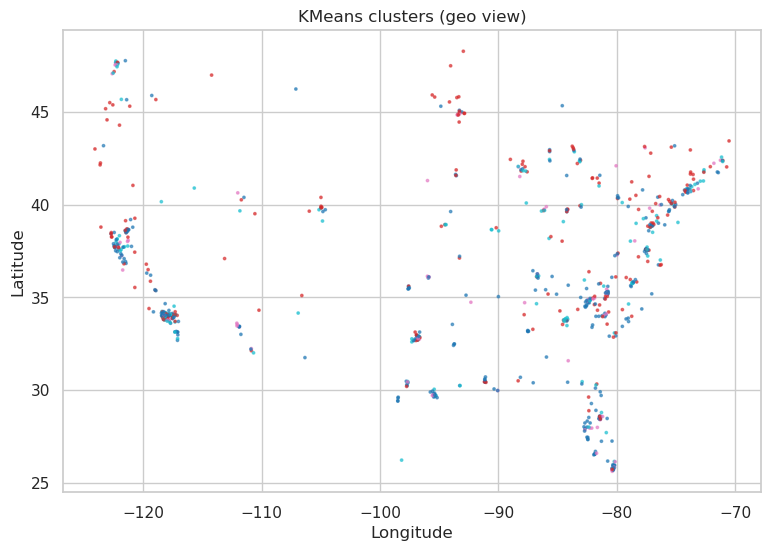

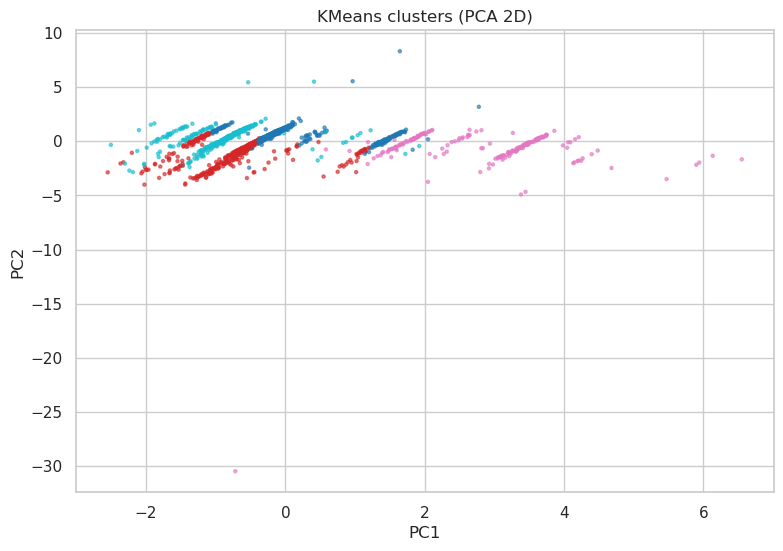

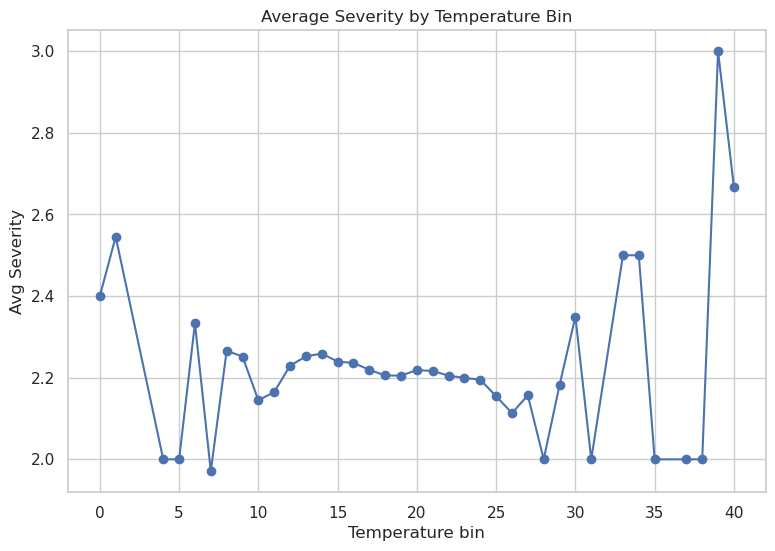

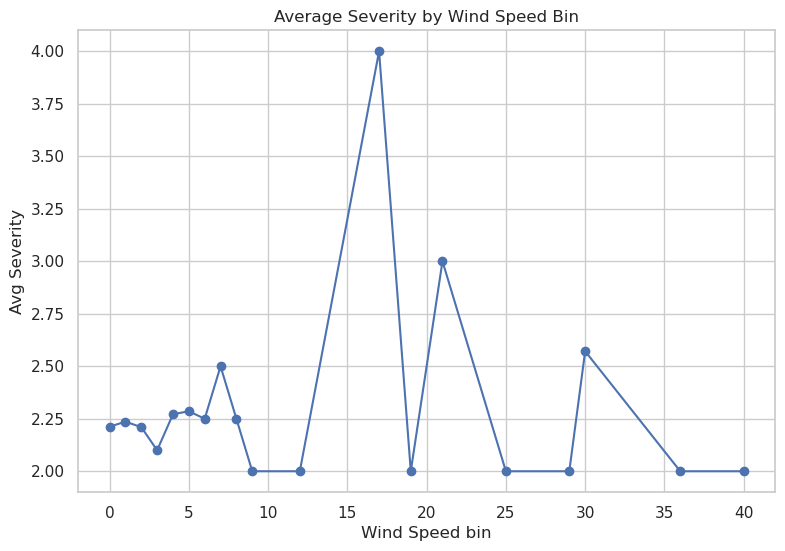

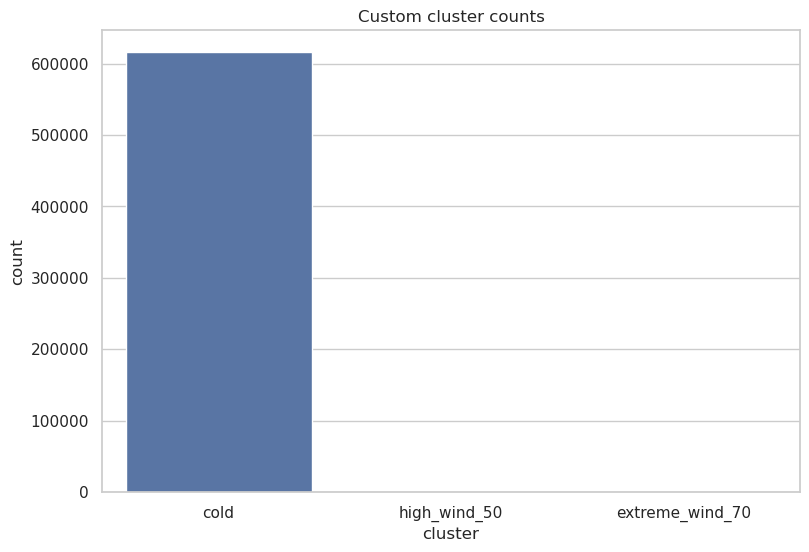

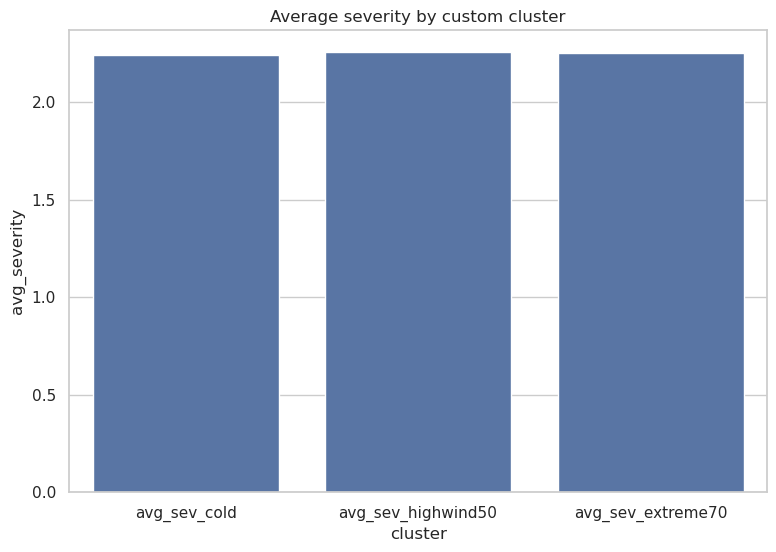

Saved cluster_summary_full.csv


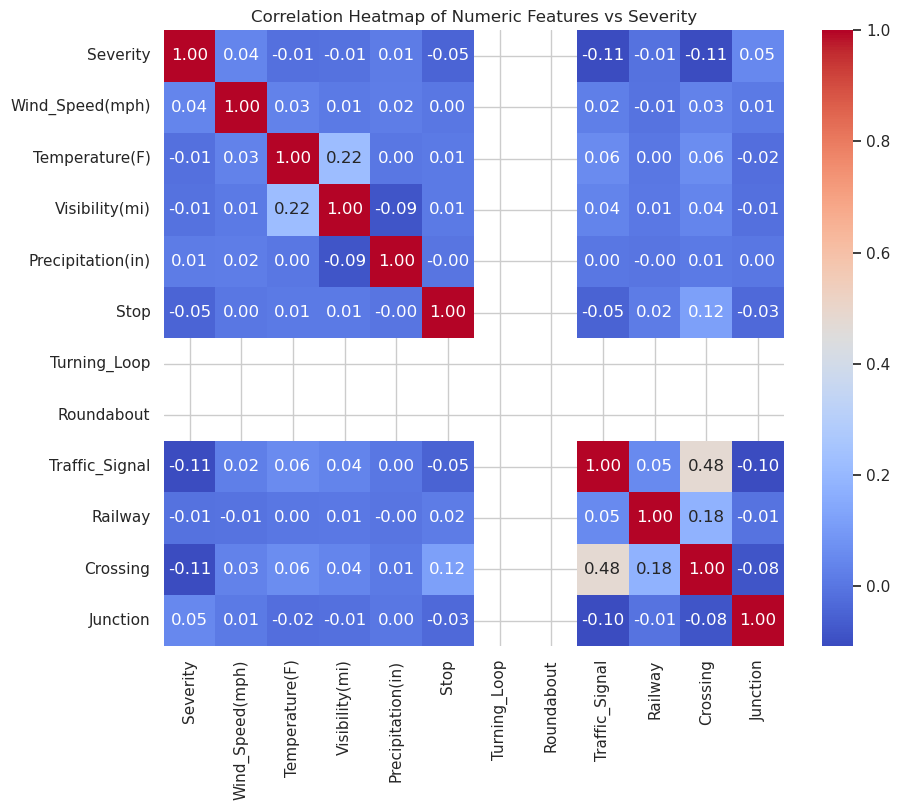

Pipeline completed successfully.


In [3]:
sns.set(style="whitegrid", rc={"figure.figsize":(9,6)})

# Create custom clusters
# -------------------------
df = df.withColumn("cold_cluster", F.when(F.col("Temperature(F)") <= 32, 1).otherwise(0))
df = df.withColumn("high_wind_50", F.when(F.col("Wind_Speed(mph)") > 50, 1).otherwise(0))
df = df.withColumn("extreme_wind_70", F.when(F.col("Wind_Speed(mph)") > 70, 1).otherwise(0))

# Quick counts
df.select(
    F.sum("cold_cluster").alias("cold_count"),
    F.sum("high_wind_50").alias("high_wind_50_count"),
    F.sum("extreme_wind_70").alias("extreme_wind_70_count")
).show()

# Aggregations by custom cluster
# -------------------------
for cluster_col in ["cold_cluster", "high_wind_50", "extreme_wind_70"]:
    agg = (
        df.groupBy(cluster_col)
          .agg(F.count("*").alias("count"),
               F.round(F.avg("Severity"),3).alias("avg_severity"))
          .orderBy(cluster_col)
    )
    print(f"Avg severity by {cluster_col}:")
    agg.show()

# Top states by accident count (if available)
if "State" in df.columns:
    top_states = df.groupBy("State").count().orderBy(F.desc("count")).limit(10).toPandas()
    print("Top states by accident count:")
    display(top_states)

# Sample for KMeans (safe)
# -------------------------
sample_frac = 0.005  # adjust for memory
df_sample = df.sample(False, sample_frac, seed=42).repartition(12)

# Define features
kmeans_feature_cols = [c for c in ["Severity","Wind_Speed(mph)","Temperature(F)",
                                   "Visibility(mi)","Precipitation(in)"] if c in df_sample.columns]
# Include boolean flags
kmeans_feature_cols += [c for c in ["Stop","Turning_Loop","Roundabout",
                                    "Traffic_Signal","Railway","Crossing","Junction"] if c in df_sample.columns]

# Assemble & scale
assembler = VectorAssembler(inputCols=kmeans_feature_cols, outputCol="unscaled_features", handleInvalid="skip")
df_feat = assembler.transform(df_sample)

scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_feat)
scaled_df = scaler_model.transform(df_feat).repartition(12)

# Run KMeans
try:
    kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="kmeans_cluster")
    kmodel = kmeans.fit(scaled_df)
    clustered_sample = kmodel.transform(scaled_df)
    clustered_sample.groupBy("kmeans_cluster").count().show()
except Exception:
    print("KMeans failed; traceback:")
    traceback.print_exc()
    raise

# PCA projection (2D)
# -------------------------
pca = PCA(k=2, inputCol="features", outputCol="pca2")
pca_model = pca.fit(clustered_sample)
pca_df = pca_model.transform(clustered_sample)

# Sample small fraction for plotting
plot_frac = min(0.05, 50000 / max(1, clustered_sample.count()))
viz_pca_pd = pca_df.select("pca2", "kmeans_cluster", "Start_Lat", "Start_Lng") \
                   .sample(False, plot_frac, seed=42).toPandas()
viz_pca_pd["pc1"] = viz_pca_pd["pca2"].apply(lambda v: float(v[0]))
viz_pca_pd["pc2"] = viz_pca_pd["pca2"].apply(lambda v: float(v[1]))

# Visualizations
# -------------------------

# Geo scatter (sample)
if {"Start_Lat","Start_Lng"}.issubset(set(df.columns)):
    geo_pd = clustered_sample.select("Start_Lat","Start_Lng","kmeans_cluster") \
                             .sample(False, 0.02, seed=42).toPandas()
    plt.scatter(geo_pd["Start_Lng"], geo_pd["Start_Lat"], c=geo_pd["kmeans_cluster"],
                s=3, cmap="tab10", alpha=0.6)
    plt.title("KMeans clusters (geo view)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.show()

# PCA scatter
plt.scatter(viz_pca_pd["pc1"], viz_pca_pd["pc2"], c=viz_pca_pd["kmeans_cluster"],
            s=5, cmap="tab10", alpha=0.6)
plt.title("KMeans clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Severity vs Temperature bins (full dataset)
if "Temperature(F)" in df.columns:
    bins = 40
    temps = df.approxQuantile("Temperature(F)", [i/bins for i in range(bins+1)], 0.01)
    df = df.withColumn("temp_bin", (F.floor((F.col("Temperature(F)") - F.lit(temps[0])) / ((temps[-1]-temps[0])/bins))).cast("int"))
    temp_summary = df.groupBy("temp_bin").agg(F.avg("Severity").alias("avg_sev"), F.count("*").alias("count")) \
                     .orderBy("temp_bin").toPandas()
    plt.plot(temp_summary["temp_bin"], temp_summary["avg_sev"], marker="o")
    plt.title("Average Severity by Temperature Bin")
    plt.xlabel("Temperature bin"); plt.ylabel("Avg Severity")
    plt.show()

# Severity vs Wind Speed bins
if "Wind_Speed(mph)" in df.columns:
    bins = 40
    winds = df.approxQuantile("Wind_Speed(mph)", [i/bins for i in range(bins+1)], 0.01)
    df = df.withColumn("wind_bin", (F.floor((F.col("Wind_Speed(mph)") - F.lit(winds[0])) / ((winds[-1]-winds[0])/bins))).cast("int"))
    wind_summary = df.groupBy("wind_bin").agg(F.avg("Severity").alias("avg_sev"), F.count("*").alias("count")) \
                     .orderBy("wind_bin").toPandas()
    plt.plot(wind_summary["wind_bin"], wind_summary["avg_sev"], marker="o")
    plt.title("Average Severity by Wind Speed Bin")
    plt.xlabel("Wind Speed bin"); plt.ylabel("Avg Severity")
    plt.show()

#  Custom cluster bar chart
custom_counts = df.select(
    F.sum("cold_cluster").alias("cold"),
    F.sum("high_wind_50").alias("high_wind_50"),
    F.sum("extreme_wind_70").alias("extreme_wind_70")
).toPandas().T.reset_index()
custom_counts.columns = ["cluster", "count"]
sns.barplot(data=custom_counts, x="cluster", y="count")
plt.title("Custom cluster counts")
plt.show()

# Avg severity by custom cluster
sev_by_custom = df.groupBy().agg(
    F.avg(F.when(F.col("cold_cluster")==1, F.col("Severity")).otherwise(None)).alias("avg_sev_cold"),
    F.avg(F.when(F.col("high_wind_50")==1, F.col("Severity")).otherwise(None)).alias("avg_sev_highwind50"),
    F.avg(F.when(F.col("extreme_wind_70")==1, F.col("Severity")).otherwise(None)).alias("avg_sev_extreme70")
).toPandas().T.reset_index()
sev_by_custom.columns = ["cluster", "avg_severity"]
sns.barplot(data=sev_by_custom, x="cluster", y="avg_severity")
plt.title("Average severity by custom cluster")
plt.show()

# Save cluster summaries
# -------------------------
cluster_summary = df.groupBy("cold_cluster","high_wind_50","extreme_wind_70") \
                    .agg(F.count("*").alias("count"), F.round(F.avg("Severity"),3).alias("avg_sev")) \
                    .toPandas()
cluster_summary.to_csv("cluster_summary_full.csv", index=False)
print("Saved cluster_summary_full.csv")

# Heatmap of numeric features vs Severity
# -------------------------
import pandas as pd

# Select numeric columns only (including integer-encoded booleans)
numeric_cols = ["Severity", "Wind_Speed(mph)", "Temperature(F)", "Visibility(mi)", 
                "Precipitation(in)"] + [c for c in ["Stop","Turning_Loop","Roundabout",
                                                    "Traffic_Signal","Railway","Crossing","Junction"] 
                                        if c in df.columns]

# Sample fraction to avoid memory issues
heatmap_frac = min(0.02, 50000 / max(1, df.count()))
df_numeric_sample = df.select(*numeric_cols).sample(False, heatmap_frac, seed=42).toPandas()

# Compute correlation
corr_matrix = df_numeric_sample.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features vs Severity")
plt.show()

# Cleanup
# -------------------------
gc.collect()
print("Pipeline completed successfully.")

In [4]:

# --------- 1) KEEP ONLY SIMPLE COLUMN TYPES  ----------------
allowed_types = (
    StringType, IntegerType, LongType, DoubleType,
    FloatType, BooleanType, DateType, TimestampType
)

safe_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, allowed_types)]

clean_df = df.select(*safe_cols)

# --------- 2) ENSURE ALL COLUMN NAMES ARE SAFE --------------
for c in clean_df.columns:
    safe_c = c.replace("(", "_").replace(")", "_").replace(" ", "_").replace("/", "_")
    if safe_c != c:
        clean_df = clean_df.withColumnRenamed(c, safe_c)

# --------- 3) CREATE REPRESENTATIVE SAMPLE -------------------
SAMPLE_FRAC = 0.02
sample_df = clean_df.sample(False, SAMPLE_FRAC, seed=42)

# --------- 4) WRITE OUT AS SPARK FOLDERS ---------------------
full_dir = "full_export_tmp"
sample_dir = "sample_export_tmp"

clean_df.write.mode("overwrite").option("header", True).csv(full_dir)
sample_df.write.mode("overwrite").option("header", True).csv(sample_dir)

# --------- 5) MERGE PART FILES INTO SINGLE CSV ---------------
def merge_spark_csv(input_dir, output_file):
    part_files = [f for f in os.listdir(input_dir) if f.startswith("part-")]

    with open(output_file, "wb") as out:
        for pf in part_files:
            with open(os.path.join(input_dir, pf), "rb") as infile:
                shutil.copyfileobj(infile, out)

merge_spark_csv(full_dir, "full_dataset.csv")
merge_spark_csv(sample_dir, "sample_dataset.csv")

# --------- 6) CLEANUP TEMP FOLDERS ---------------------------
shutil.rmtree(full_dir)
shutil.rmtree(sample_dir)

print("✔ Export completed successfully!")
print("✔ Created: full_dataset.csv")
print("✔ Created: sample_dataset.csv")

✔ Export completed successfully!
✔ Created: full_dataset.csv
✔ Created: sample_dataset.csv


## Evaluation

### Business Insight/Recommendation 1
the presence of traffic signals appears to have the strongest effect of reducing severity of accidents. after further inspection in tableau, roundabouts seem to be around 4% more effective
than stop lights at reducing severity of collisions.
This highlights the importance of having better infrastructure at intersections. Stop signs, traffic lights, and roundabouts all show a decrease in severity.

### Business Insight/Recommendation 2
Severity of accidents tends to increase at temperatures slightly above freezing, not always below 32F. The severity spikes at around 5 degrees and again at around 40 degrees. 
This is likely due to black ice in shaded or low traffic areas. 
This highlights the importance of continuing to salt or sand streets even if the outside temperature is not quite freezing.

### Business Insight/Recommendation 3
Although more populous areas tend to have higher rates of accidents, traffic accidents in rural areas, likely along highways have higher average severity.
This highlights the importance of speed regulation in rural areas.

### Tableau Dashboard link
https://public.tableau.com/app/profile/ben.harper5219/viz/USaccidentdatasetanalysis/Dashboard1?publish=yes

## Conclusion and Next Steps
My conclusion from this data exploration is that traffic accidents have many factors that we cannot control, but there are many steps that can be taken to
prevent them or at least mitigate the severity. Increased speed regulation on interstates, improved infrastructure, and dynamic response to weather changes will indeed have a
positive effect on driver safety.